### Filtering the dataset samples before training the model

I manually listened to the dataset recordings and I observed that the noise is usually voices in the background and rustling. Thus I will need a low pass filter to cut it.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import scipy.signal as signalpy
import wave
import sys
import math
import contextlib
import IPython
import os

fname = 'samples/eminem-30s.wav'
outname = 'samples/eminem-f.wav'

cutOffFrequency = 1000.0

# from http://stackoverflow.com/questions/13728392/moving-average-or-running-mean
def running_mean(x, windowSize):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[windowSize:] - cumsum[:-windowSize]) / windowSize

# from http://stackoverflow.com/questions/2226853/interpreting-wav-data/2227174#2227174
def interpret_wav(raw_bytes, n_frames, n_channels, sample_width, interleaved = True):

    if sample_width == 1:
        dtype = np.uint8 # unsigned char
    elif sample_width == 2:
        dtype = np.int16 # signed 2-byte short
    else:
        raise ValueError("Only supports 8 and 16 bit audio formats.")

    channels = np.frombuffer(raw_bytes, dtype=dtype)

    if interleaved:
        # channels are interleaved, i.e. sample N of channel M follows sample N of channel M-1 in raw data
        channels.shape = (n_frames, n_channels)
        channels = channels.T
    else:
        # channels are not interleaved. All samples from channel M occur before all samples from channel M-1
        channels.shape = (n_channels, n_frames)

    return channels

with contextlib.closing(wave.open(fname,'rb')) as spf:
    sampleRate = spf.getframerate()
    ampWidth = spf.getsampwidth()
    nChannels = spf.getnchannels()
    nFrames = spf.getnframes()

    # Extract Raw Audio from multi-channel Wav File
    signal = spf.readframes(nFrames*nChannels)
    spf.close()
    channels = interpret_wav(signal, nFrames, nChannels, ampWidth, True)

    # get window size
    # from http://dsp.stackexchange.com/questions/9966/what-is-the-cut-off-frequency-of-a-moving-average-filter
    freqRatio = (cutOffFrequency/sampleRate)
    N = int(math.sqrt(0.196196 + freqRatio**2)/freqRatio)

    # Use moviung average (only on first channel)
    filtered = running_mean(channels[0], N).astype(channels.dtype)

    wav_file = wave.open(outname, "w")
    wav_file.setparams((1, ampWidth, sampleRate, nFrames, spf.getcomptype(), spf.getcompname()))
    wav_file.writeframes(filtered.tobytes('C'))
    wav_file.close()

### Useful functions

In [5]:
def extract_audio(fname, tStart=None, tEnd=None):
    with contextlib.closing(wave.open(fname,'rb')) as spf:
        sampleRate = spf.getframerate()
        ampWidth = spf.getsampwidth()
        nChannels = spf.getnchannels()
        nFrames = spf.getnframes()

        startFrame, endFrame, segFrames = get_start_end_frames(nFrames, sampleRate, tStart, tEnd)

        # Extract Raw Audio from multi-channel Wav File
        spf.setpos(startFrame)
        sig = spf.readframes(segFrames)
        spf.close()

        channels = interpret_wav(sig, segFrames, nChannels, ampWidth, True)

        return (channels, nChannels, sampleRate, ampWidth, nFrames)
    
def convert_to_mono(channels, nChannels, outputType):
    if nChannels == 2:
        samples = np.mean(np.array([channels[0], channels[1]]), axis=0)  # Convert to mono
    else:
        samples = channels[0]

    return samples.astype(outputType)

def get_start_end_frames(nFrames, sampleRate, tStart=None, tEnd=None):

    if tStart and tStart*sampleRate<nFrames:
        start = tStart*sampleRate
    else:
        start = 0

    if tEnd and tEnd*sampleRate<nFrames and tEnd*sampleRate>start:
        end = tEnd*sampleRate
    else:
        end = nFrames

    return (start,end,end-start)

def plot_specgram(samples, sampleRate, tStart=None, tEnd=None):
    plt.figure(figsize=(20,10))
    plt.specgram(samples, Fs=sampleRate, NFFT=1024, noverlap=192, cmap='nipy_spectral', xextent=(tStart,tEnd))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

def plot_audio_samples(title, samples, sampleRate, tStart=None, tEnd=None):
    if not tStart:
        tStart = 0

    if not tEnd or tStart>tEnd:
        tEnd = len(samples)/sampleRate

    f, axarr = plt.subplots(2, sharex=True, figsize=(20,10))
    axarr[0].set_title(title)
    axarr[0].plot(np.linspace(tStart, tEnd, len(samples)), samples)
    axarr[1].specgram(samples, Fs=sampleRate, NFFT=1024, noverlap=192, cmap='nipy_spectral', xextent=(tStart,tEnd))
    #get_specgram(axarr[1], samples, sampleRate, tStart, tEnd)

    axarr[0].set_ylabel('Amplitude')
    axarr[1].set_ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')

    plt.show()

### Filters

In [6]:
def fir_low_pass(samples, fs, fL, N, outputType):
    # Referece: https://fiiir.com

    fL = fL / fs

    # Compute sinc filter.
    h = np.sinc(2 * fL * (np.arange(N) - (N - 1) / 2.))
    # Apply window.
    h *= np.hamming(N)
    # Normalize to get unity gain.
    h /= np.sum(h)
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)
    return s

def fir_high_pass(samples, fs, fH, N, outputType):
    # Referece: https://fiiir.com

    fH = fH / fs

    # Compute sinc filter.
    h = np.sinc(2 * fH * (np.arange(N) - (N - 1) / 2.))
    # Apply window.
    h *= np.hamming(N)
    # Normalize to get unity gain.
    h /= np.sum(h)
    # Create a high-pass filter from the low-pass filter through spectral inversion.
    h = -h
    h[int((N - 1) / 2)] += 1
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)
    return s

def fir_band_reject(samples, fs, fL, fH, NL, NH, outputType):
    # Referece: https://fiiir.com

    fH = fH / fs
    fL = fL / fs

    # Compute a low-pass filter with cutoff frequency fL.
    hlpf = np.sinc(2 * fL * (np.arange(NL) - (NL - 1) / 2.))
    hlpf *= np.blackman(NL)
    hlpf /= np.sum(hlpf)
    # Compute a high-pass filter with cutoff frequency fH.
    hhpf = np.sinc(2 * fH * (np.arange(NH) - (NH - 1) / 2.))
    hhpf *= np.blackman(NH)
    hhpf /= np.sum(hhpf)
    hhpf = -hhpf
    hhpf[int((NH - 1) / 2)] += 1
    # Add both filters.
    if NH >= NL:
        h = hhpf
        h[int((NH - NL) / 2) : int((NH - NL) / 2 + NL)] += hlpf
    else:
        h = hlpf
        h[int((NL - NH) / 2) : int((NL - NH) / 2 + NH)] += hhpf
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)

    return s

def fir_band_pass(samples, fs, fL, fH, NL, NH, outputType):
    # Referece: https://fiiir.com

    fH = fH / fs
    fL = fL / fs

    # Compute a low-pass filter with cutoff frequency fH.
    hlpf = np.sinc(2 * fH * (np.arange(NH) - (NH - 1) / 2.))
    hlpf *= np.blackman(NH)
    hlpf /= np.sum(hlpf)
    # Compute a high-pass filter with cutoff frequency fL.
    hhpf = np.sinc(2 * fL * (np.arange(NL) - (NL - 1) / 2.))
    hhpf *= np.blackman(NL)
    hhpf /= np.sum(hhpf)
    hhpf = -hhpf
    hhpf[int((NL - 1) / 2)] += 1
    # Convolve both filters.
    h = np.convolve(hlpf, hhpf)
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)

    return s

def butter_low_pass(samples, fs, fL, order, outputType):
    # Normalize the cutoff frequency
    fN = fs / 2
    fL_norm = fL / fN

    # Calculate the Butterworth filter coefficients
    b, a = signalpy.butter(order, fL_norm, btype='low')

    # Apply the filter to the signal
    s = signalpy.lfilter(b, a, samples).astype(outputType)

    return s

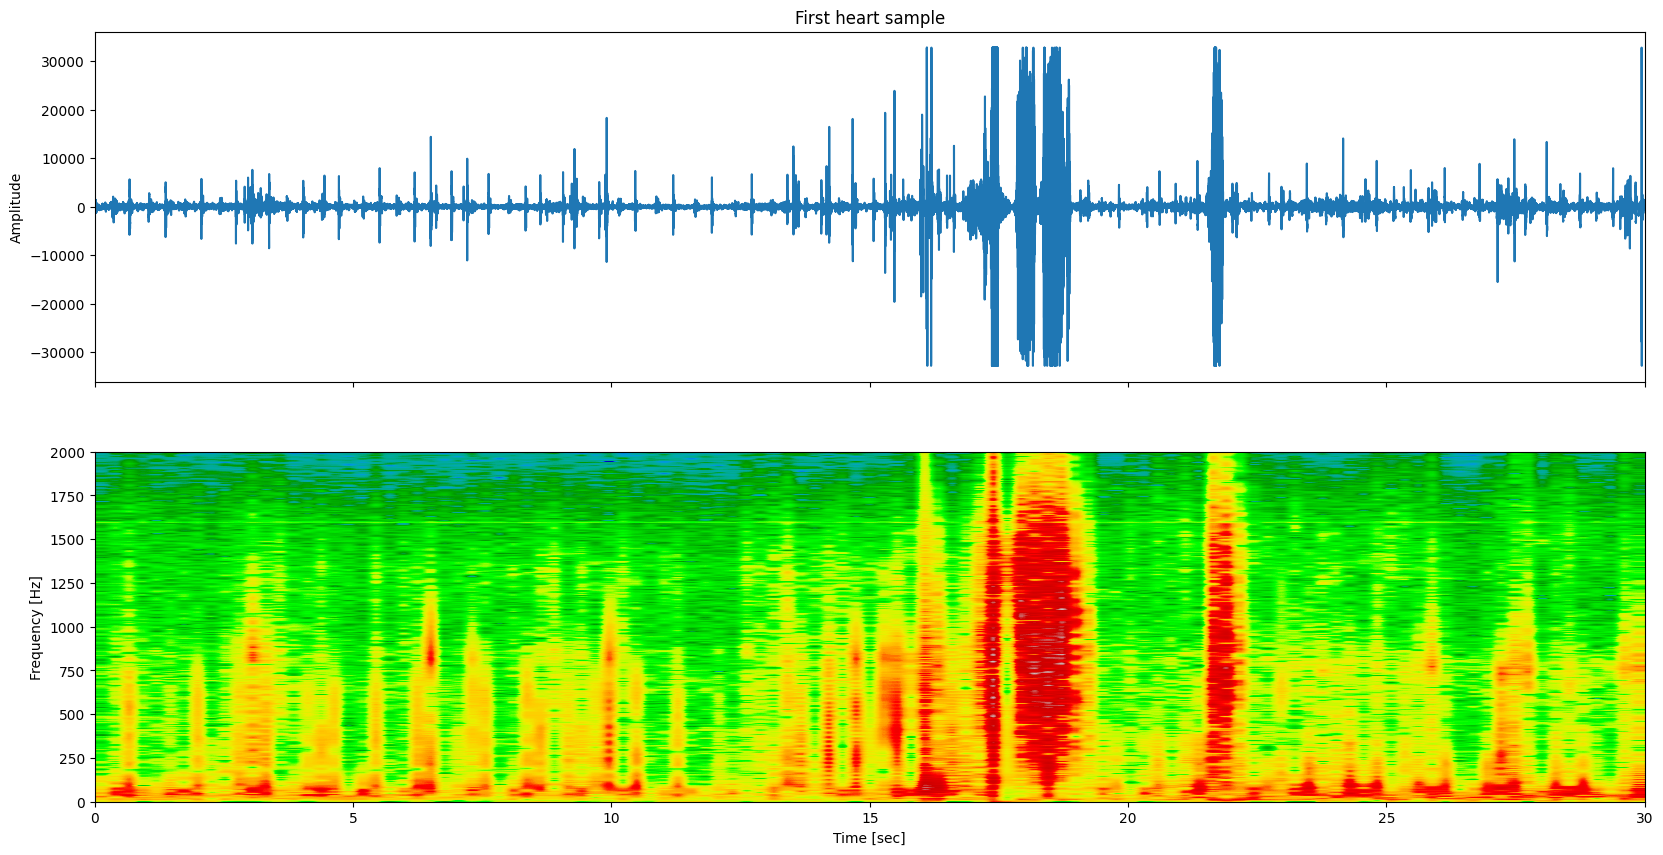

In [7]:
# 2530_AV.wav

tStart = 0
tEnd = 30

channels, nChannels, sampleRate, ampWidth, nFrames = extract_audio('phonocardiogram_dataset/training_data/training_data/2530_AV.wav', tStart, tEnd)
samples = convert_to_mono(channels, nChannels, np.int16)

plot_audio_samples("First heart sample", samples, sampleRate, tStart, tEnd)

In [8]:
audio_file = 'phonocardiogram_dataset/training_data/training_data/2530_AV.wav'

IPython.display.Audio( audio_file )

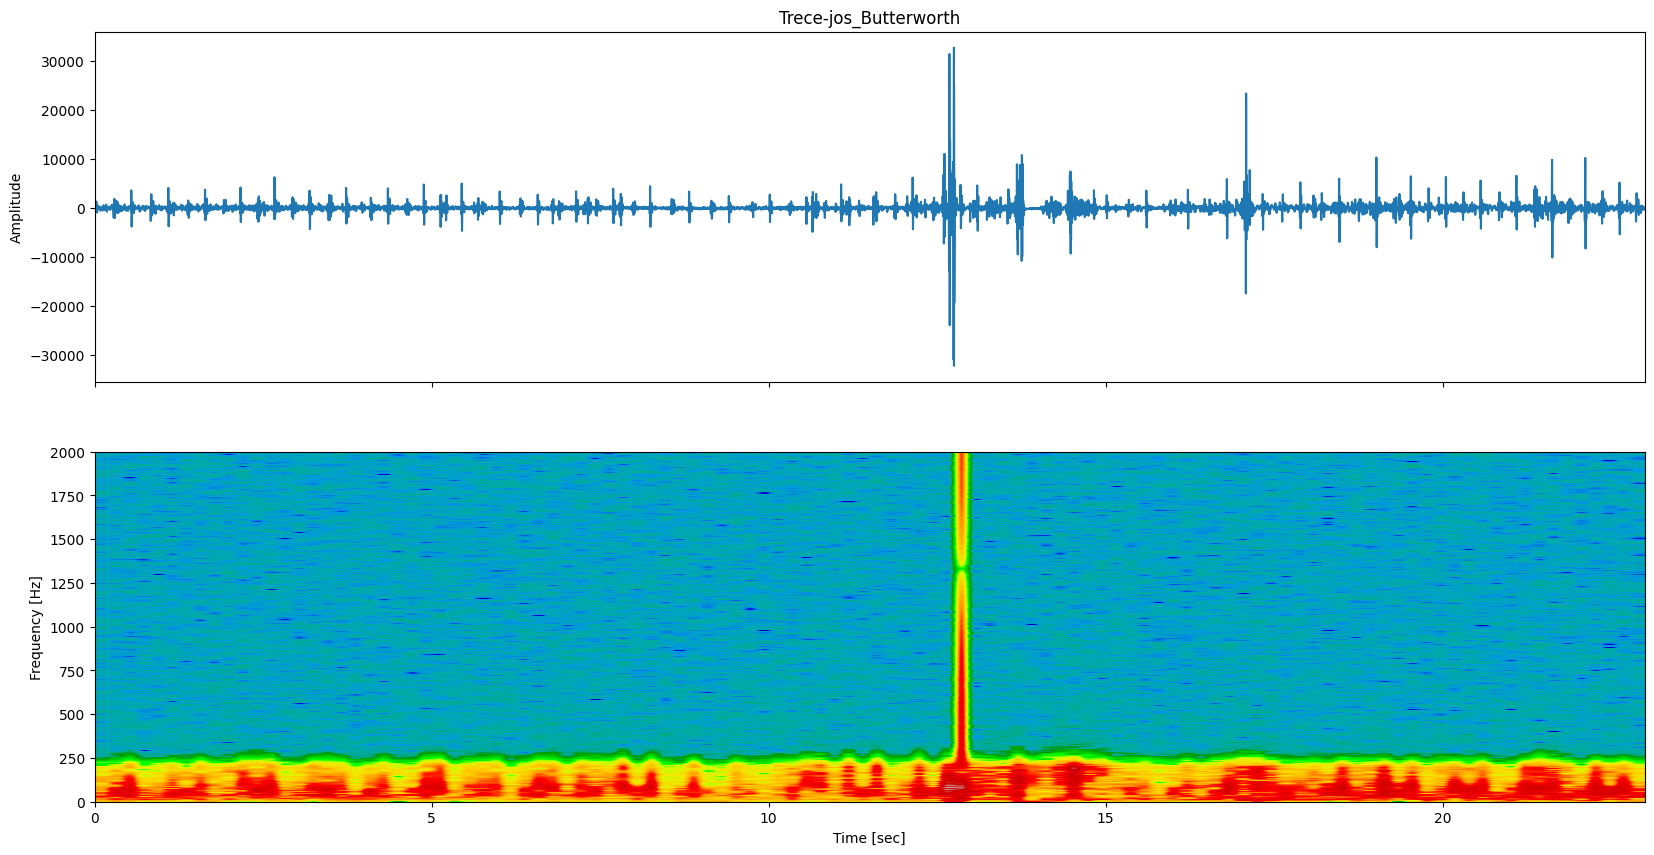

In [9]:
audio_file = 'phonocardiogram_dataset/training_data/training_data/2530_AV.wav'

tStart=0
tEnd=23

channels, nChannels, sampleRate, ampWidth, nFrames = extract_audio(audio_file, tStart, tEnd)
samples = convert_to_mono(channels, nChannels, np.int16)

#Trece jos

# sample_low_pass = fir_low_pass(samples, sampleRate , 200 , 551, np.int16)
sample_low_pass = butter_low_pass(samples, sampleRate , 200 , 19, np.int16)
plot_audio_samples("Trece-jos_Butterworth", sample_low_pass, sampleRate, tStart, tEnd)

# sample_low_pass_amplified =  np.multiply(sample_low_pass, 4)

# plot_audio_samples("Amplificat", sample_low_pass_amplified, sampleRate, tStart, tEnd)

wavfile.write('phonocardiogram_dataset/training_data/filtered_data/2530_AV_filtered.wav', sampleRate, sample_low_pass)



IPython.display.Audio( 'phonocardiogram_dataset/training_data/filtered_data/2530_AV_filtered.wav' )

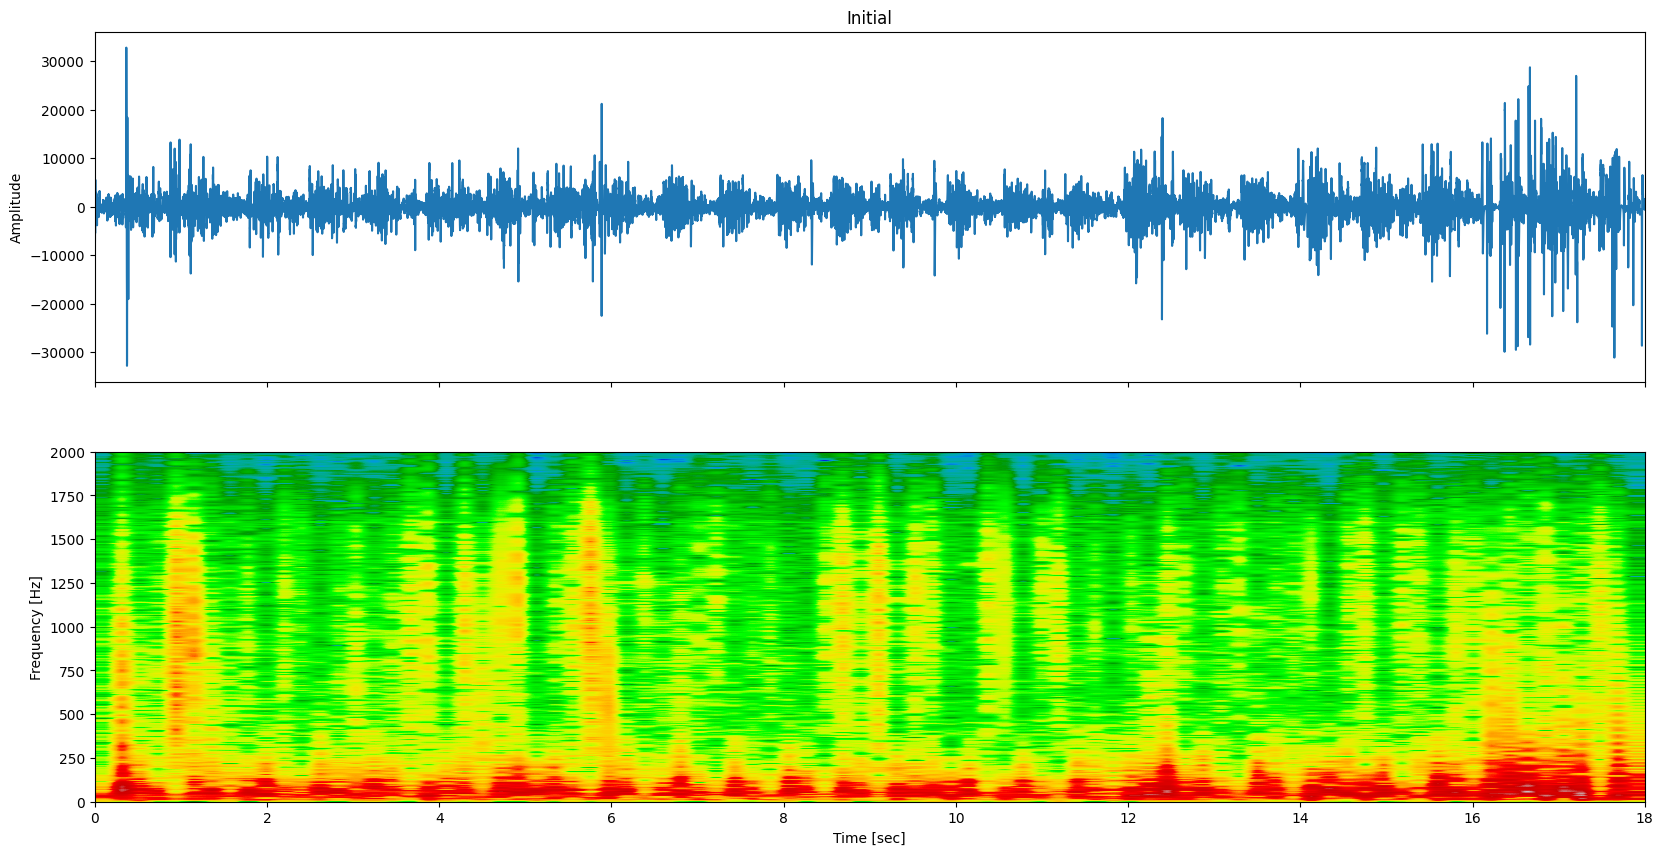

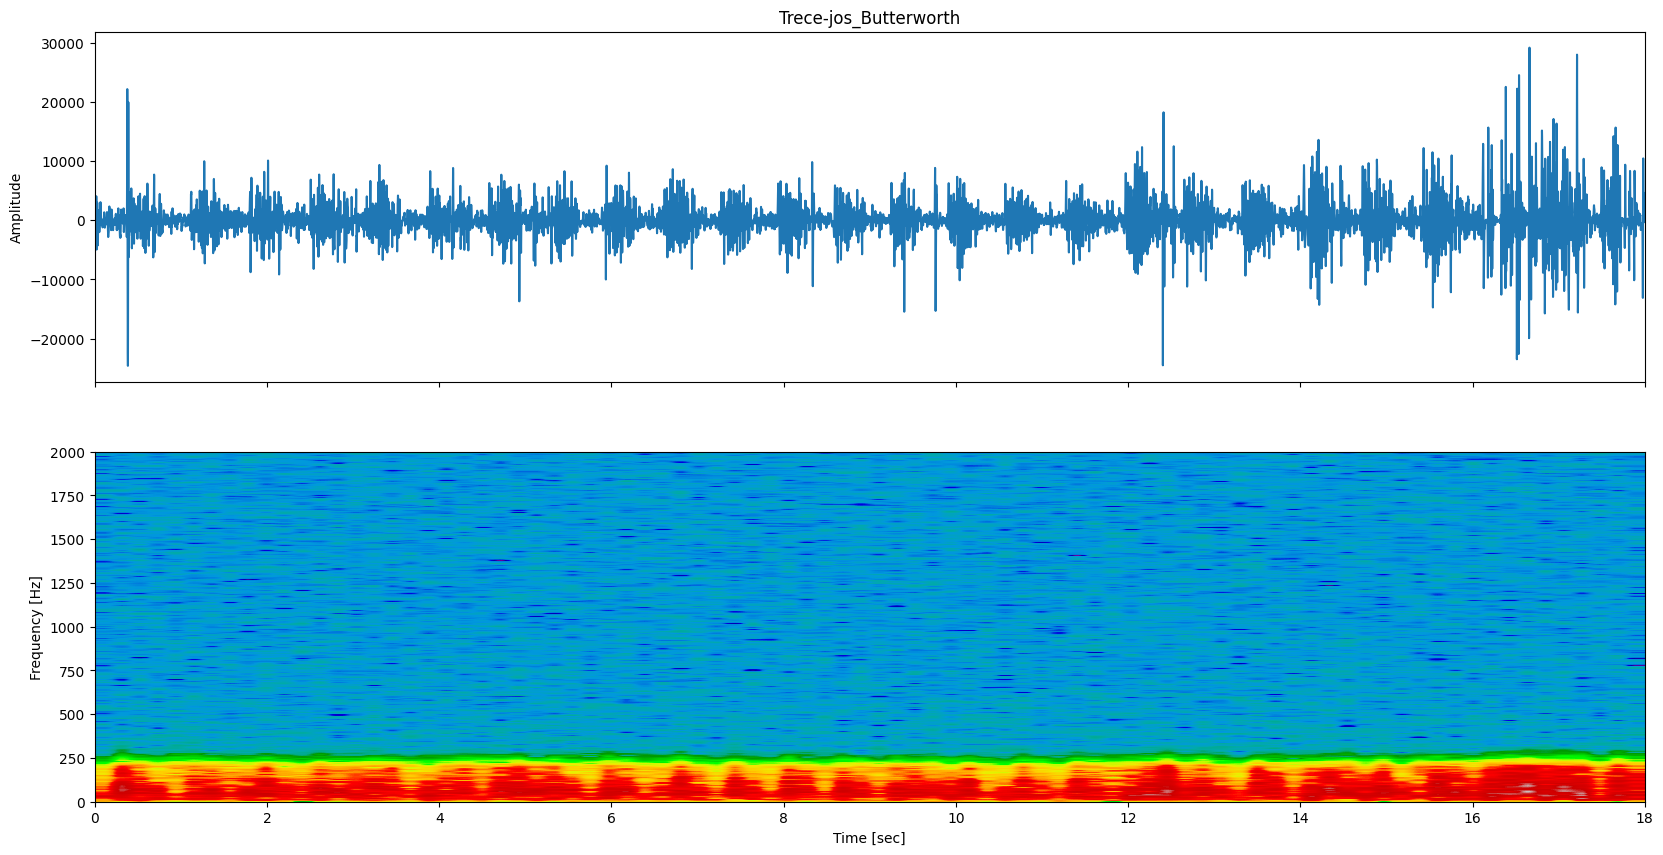

In [10]:
audio_file = 'phonocardiogram_dataset/training_data/training_data/9979_AV.wav'

tStart=0
tEnd=18

channels, nChannels, sampleRate, ampWidth, nFrames = extract_audio(audio_file, tStart, tEnd)
samples = convert_to_mono(channels, nChannels, np.int16)

plot_audio_samples("Initial", samples, sampleRate, tStart, tEnd)

#Trece jos

# sample_low_pass = fir_low_pass(samples, sampleRate , 200 , 551, np.int16)
sample_low_pass = butter_low_pass(samples, sampleRate , 200 , 19, np.int16)
plot_audio_samples("Trece-jos_Butterworth", sample_low_pass, sampleRate, tStart, tEnd)

# sample_low_pass_amplified =  np.multiply(sample_low_pass, 4)

# plot_audio_samples("Amplificat", sample_low_pass_amplified, sampleRate, tStart, tEnd)

wavfile.write('phonocardiogram_dataset/training_data/filtered_data/9979_AV_filtered.wav', sampleRate, sample_low_pass)



IPython.display.Audio( 'phonocardiogram_dataset/training_data/filtered_data/9979_AV_filtered.wav' )

In [14]:
# Set the directory paths
input_dir = 'phonocardiogram_dataset/training_data/training_data'
output_dir = 'phonocardiogram_dataset/training_data/filtered_data'


# Set the filter parameters
fL = 200
order = 19
outputType = np.int16

# Iterate over all files in the input directory

for file_name in os.listdir(input_dir):
    # Check if the file is a .wav file
    if file_name.endswith('.wav'):
        # Set the input and output file paths
        input_path = os.path.join(input_dir, file_name)
        output_path = os.path.join(output_dir, file_name[:-4] + '_filtered.wav') # I added the _filtered suffix to the output file name
        
        # Load the audio file and apply the filter
        sample_rate, samples = wavfile.read(input_path)
        sample_low_pass = butter_low_pass(samples, sample_rate, fL, order, outputType)
        
        # Save the filtered audio to a new file
        wavfile.write(output_path, sample_rate, sample_low_pass)

### Verification

In [25]:
input_dir = 'phonocardiogram_dataset/training_data/training_data'
output_dir = 'phonocardiogram_dataset/training_data/filtered_data'
file_name = '13918_AV'

IPython.display.Audio(os.path.join(input_dir , file_name + '.wav'))

In [26]:
IPython.display.Audio(os.path.join(output_dir , file_name + '_filtered.wav'))